In [5]:
# IMPORT LIBRARIES
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os

# Deep Learning & NLP
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    get_linear_schedule_with_warmup
)
from torch.optim import AdamW

# Machine Learning
from sklearn.metrics import (
    classification_report, confusion_matrix,
    accuracy_score, f1_score, precision_recall_fscore_support
)

from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

print(f"PyTorch Version: {torch.__version__}")
print(f"CUDA Available: {torch.cuda.is_available()}")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

PyTorch Version: 2.9.0+cu126
CUDA Available: True
Device: cuda


In [6]:
# LOAD PROCESSED DATA

X_train = np.load('processed_data/X_train.npy', allow_pickle=True)
X_val = np.load('processed_data/X_val.npy', allow_pickle=True)
X_test = np.load('processed_data/X_test.npy', allow_pickle=True)
y_train = np.load('processed_data/y_train.npy', allow_pickle=True)
y_val = np.load('processed_data/y_val.npy', allow_pickle=True)
y_test = np.load('processed_data/y_test.npy', allow_pickle=True)

with open('processed_data/metadata.pkl', 'rb') as f:
    metadata = pickle.load(f)


def preprocess_text(text):
    return str(text)

with open('processed_data/preprocessing_config.pkl', 'rb') as f:
    preprocessing_config = pickle.load(f)

class_weight_dict = metadata['class_weights']
label_mapping = metadata['label_mapping']
preprocess_text = preprocessing_config['preprocess_function']

print(f"\nData loaded successfully!")
print(f"Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")


Data loaded successfully!
Train: 4510, Val: 967, Test: 967


In [7]:
# LOAD PRETRAINED MODEL

MODEL_NAME = "indolem/indobertweet-base-uncased"

print(f"\nLoading: {MODEL_NAME}")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=3,
    ignore_mismatched_sizes=True
)

model.to(device)
print("Model loaded successfully!")

# Model info
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")


Loading: indolem/indobertweet-base-uncased


tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/445M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indolem/indobertweet-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded successfully!

Total parameters: 110,560,515
Trainable parameters: 110,560,515


In [8]:
# DATASET & DATALOADER

class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

MAX_LEN = 128
BATCH_SIZE = 16

train_dataset = SentimentDataset(X_train, y_train, tokenizer, MAX_LEN)
val_dataset = SentimentDataset(X_val, y_val, tokenizer, MAX_LEN)
test_dataset = SentimentDataset(X_test, y_test, tokenizer, MAX_LEN)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

print(f"\nConfiguration:")
print(f"  Max Length: {MAX_LEN}")
print(f"  Batch Size: {BATCH_SIZE}")
print(f"  Train Batches: {len(train_loader)}")
print(f"  Val Batches: {len(val_loader)}")
print(f"  Test Batches: {len(test_loader)}")


Configuration:
  Max Length: 128
  Batch Size: 16
  Train Batches: 282
  Val Batches: 61
  Test Batches: 61


In [9]:
# TRAINING CONFIGURATION

EPOCHS = 5
LEARNING_RATE = 2e-5

optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=0.01)

total_steps = len(train_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

# Weighted loss for imbalance
class_weights_tensor = torch.tensor(
    list(class_weight_dict.values()),
    dtype=torch.float
).to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

print(f"\nTraining Setup:")
print(f"  Epochs: {EPOCHS}")
print(f"  Learning Rate: {LEARNING_RATE}")
print(f"  Optimizer: AdamW (weight_decay=0.01)")
print(f"  Scheduler: Linear warmup")
print(f"  Loss: Weighted CrossEntropyLoss")
print(f"  Class Weights: {class_weight_dict}")


Training Setup:
  Epochs: 5
  Learning Rate: 2e-05
  Optimizer: AdamW (weight_decay=0.01)
  Scheduler: Linear warmup
  Loss: Weighted CrossEntropyLoss
  Class Weights: {0: np.float64(0.45031446540880504), 1: np.float64(2.930422919508868), 2: np.float64(2.2826780021253987)}


In [10]:
# TRAINING FUNCTIONS

def train_epoch(model, data_loader, criterion, optimizer, device, scheduler):
    model.train()
    losses = []
    correct = 0
    total = 0

    progress_bar = tqdm(data_loader, desc='Training')

    for batch in progress_bar:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = criterion(outputs.logits, labels)

        _, preds = torch.max(outputs.logits, dim=1)
        correct += torch.sum(preds == labels).item()
        total += labels.size(0)

        losses.append(loss.item())

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()

        progress_bar.set_postfix({'loss': loss.item(), 'acc': correct/total})

    return correct / total, np.mean(losses)

def eval_model(model, data_loader, criterion, device):
    model.eval()
    losses = []
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in tqdm(data_loader, desc='Evaluating'):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = criterion(outputs.logits, labels)

            _, preds = torch.max(outputs.logits, dim=1)
            correct += torch.sum(preds == labels).item()
            total += labels.size(0)

            losses.append(loss.item())

    return correct / total, np.mean(losses)

In [11]:
# TRAINING LOOP

os.makedirs('models', exist_ok=True)
os.makedirs('results', exist_ok=True)

history = {
    'train_acc': [],
    'train_loss': [],
    'val_acc': [],
    'val_loss': []
}

best_accuracy = 0

print("\nStarting training...\n")

for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 80)

    train_acc, train_loss = train_epoch(
        model, train_loader, criterion, optimizer, device, scheduler
    )
    print(f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}')

    val_acc, val_loss = eval_model(model, val_loader, criterion, device)
    print(f'Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}')

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'models/indobertweet_best_model.bin')
        best_accuracy = val_acc
        print(f'Best model saved (Val Acc: {best_accuracy:.4f})')

    print()

print("Training completed!")

# Save history
with open('results/indobertweet_history.pkl', 'wb') as f:
    pickle.dump(history, f)



Starting training...

Epoch 1/5
--------------------------------------------------------------------------------


Training:   0%|          | 0/282 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/445M [00:00<?, ?B/s]

Training: 100%|██████████| 282/282 [01:36<00:00,  2.93it/s, loss=0.42, acc=0.778]


Train Loss: 0.5947 | Train Acc: 0.7783


Evaluating: 100%|██████████| 61/61 [00:06<00:00,  9.08it/s]


Val Loss: 0.3396 | Val Acc: 0.8542
Best model saved (Val Acc: 0.8542)

Epoch 2/5
--------------------------------------------------------------------------------


Training: 100%|██████████| 282/282 [01:37<00:00,  2.89it/s, loss=0.0772, acc=0.924]


Train Loss: 0.2639 | Train Acc: 0.9237


Evaluating: 100%|██████████| 61/61 [00:06<00:00,  9.00it/s]


Val Loss: 0.3555 | Val Acc: 0.9121
Best model saved (Val Acc: 0.9121)

Epoch 3/5
--------------------------------------------------------------------------------


Training: 100%|██████████| 282/282 [01:38<00:00,  2.85it/s, loss=0.176, acc=0.972]


Train Loss: 0.1260 | Train Acc: 0.9716


Evaluating: 100%|██████████| 61/61 [00:06<00:00,  8.82it/s]


Val Loss: 0.5485 | Val Acc: 0.9276
Best model saved (Val Acc: 0.9276)

Epoch 4/5
--------------------------------------------------------------------------------


Training: 100%|██████████| 282/282 [01:39<00:00,  2.85it/s, loss=0.000838, acc=0.988]


Train Loss: 0.0577 | Train Acc: 0.9885


Evaluating: 100%|██████████| 61/61 [00:06<00:00,  8.82it/s]


Val Loss: 0.6407 | Val Acc: 0.9338
Best model saved (Val Acc: 0.9338)

Epoch 5/5
--------------------------------------------------------------------------------


Training: 100%|██████████| 282/282 [01:39<00:00,  2.84it/s, loss=0.000501, acc=0.995]


Train Loss: 0.0231 | Train Acc: 0.9951


Evaluating: 100%|██████████| 61/61 [00:06<00:00,  8.78it/s]

Val Loss: 0.6066 | Val Acc: 0.9317

Training completed!


Training history saved


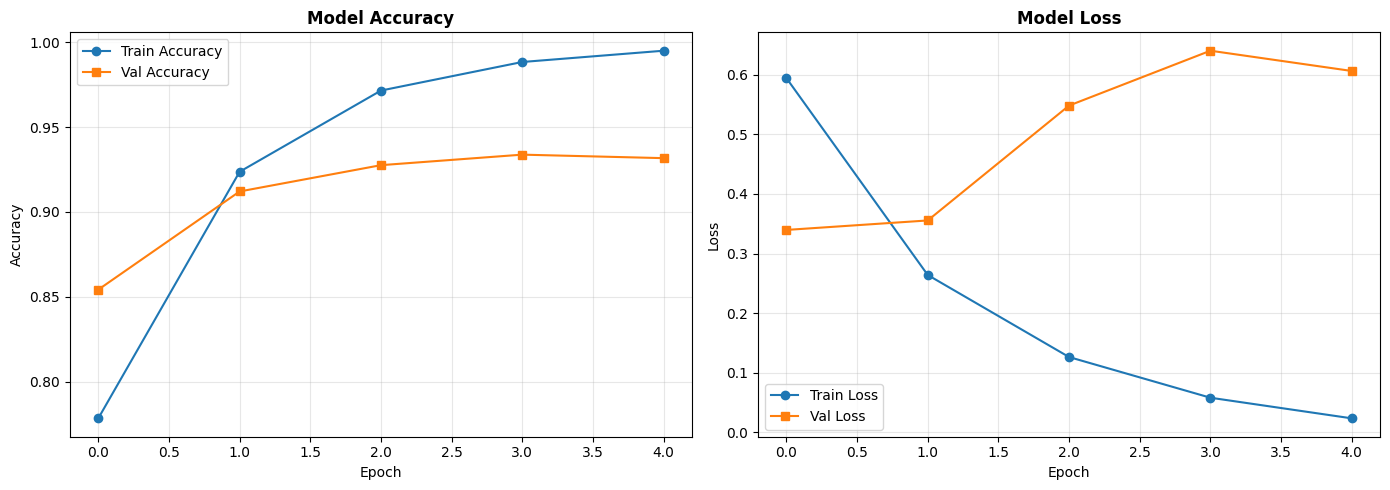

In [12]:
# TRAINING VISUALIZATION

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(history['train_acc'], label='Train Accuracy', marker='o')
axes[0].plot(history['val_acc'], label='Val Accuracy', marker='s')
axes[0].set_title('Model Accuracy', fontweight='bold', fontsize=12)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(history['train_loss'], label='Train Loss', marker='o')
axes[1].plot(history['val_loss'], label='Val Loss', marker='s')
axes[1].set_title('Model Loss', fontweight='bold', fontsize=12)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('results/indobertweet_training_history.png', dpi=300, bbox_inches='tight')
print("Training history saved")
plt.show()

In [13]:
# EVALUATION ON TEST SET

model.load_state_dict(torch.load('models/indobertweet_best_model.bin'))

test_acc, test_loss = eval_model(model, test_loader, criterion, device)

print(f"\nTest Results:")
print(f"  Test Loss: {test_loss:.4f}")
print(f"  Test Accuracy: {test_acc:.4f}")

# Get predictions
def get_predictions(model, data_loader, device):
    model.eval()
    predictions = []
    true_labels = []
    pred_probs = []

    with torch.no_grad():
        for batch in tqdm(data_loader, desc='Predicting'):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            probs = torch.softmax(outputs.logits, dim=1)
            _, preds = torch.max(outputs.logits, dim=1)

            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
            pred_probs.extend(probs.cpu().numpy())

    return np.array(predictions), np.array(true_labels), np.array(pred_probs)

y_pred, y_true, y_pred_probs = get_predictions(model, test_loader, device)

# Save predictions
np.save('results/indobertweet_predictions.npy', y_pred)
np.save('results/indobertweet_pred_probs.npy', y_pred_probs)


Evaluating: 100%|██████████| 61/61 [00:06<00:00,  8.80it/s]



Test Results:
  Test Loss: 0.5965
  Test Accuracy: 0.9204


Predicting: 100%|██████████| 61/61 [00:06<00:00,  8.85it/s]


In [14]:
# DETAILED METRICS

label_names = ['Negative', 'Neutral', 'Positive']
report = classification_report(y_true, y_pred, target_names=label_names, digits=4)
print("\n" + report)

macro_f1 = f1_score(y_true, y_pred, average='macro')
weighted_f1 = f1_score(y_true, y_pred, average='weighted')

print(f"\nAdditional Metrics:")
print(f"  Macro F1-Score: {macro_f1:.4f}")
print(f"  Weighted F1-Score: {weighted_f1:.4f}")

# Per-class metrics
precision, recall, f1, support = precision_recall_fscore_support(
    y_true, y_pred, labels=[0, 1, 2]
)

print(f"\nPer-Class Performance:")
print("-" * 60)
for i, label in enumerate(label_names):
    print(f"{label:10s} | P: {precision[i]:.4f} | R: {recall[i]:.4f} | "
          f"F1: {f1[i]:.4f} | Support: {support[i]}")


              precision    recall  f1-score   support

    Negative     0.9526    0.9539    0.9532       716
     Neutral     0.8302    0.8000    0.8148       110
    Positive     0.8264    0.8440    0.8351       141

    accuracy                         0.9204       967
   macro avg     0.8697    0.8660    0.8677       967
weighted avg     0.9203    0.9204    0.9203       967


Additional Metrics:
  Macro F1-Score: 0.8677
  Weighted F1-Score: 0.9203

Per-Class Performance:
------------------------------------------------------------
Negative   | P: 0.9526 | R: 0.9539 | F1: 0.9532 | Support: 716
Neutral    | P: 0.8302 | R: 0.8000 | F1: 0.8148 | Support: 110
Positive   | P: 0.8264 | R: 0.8440 | F1: 0.8351 | Support: 141


Confusion matrix saved


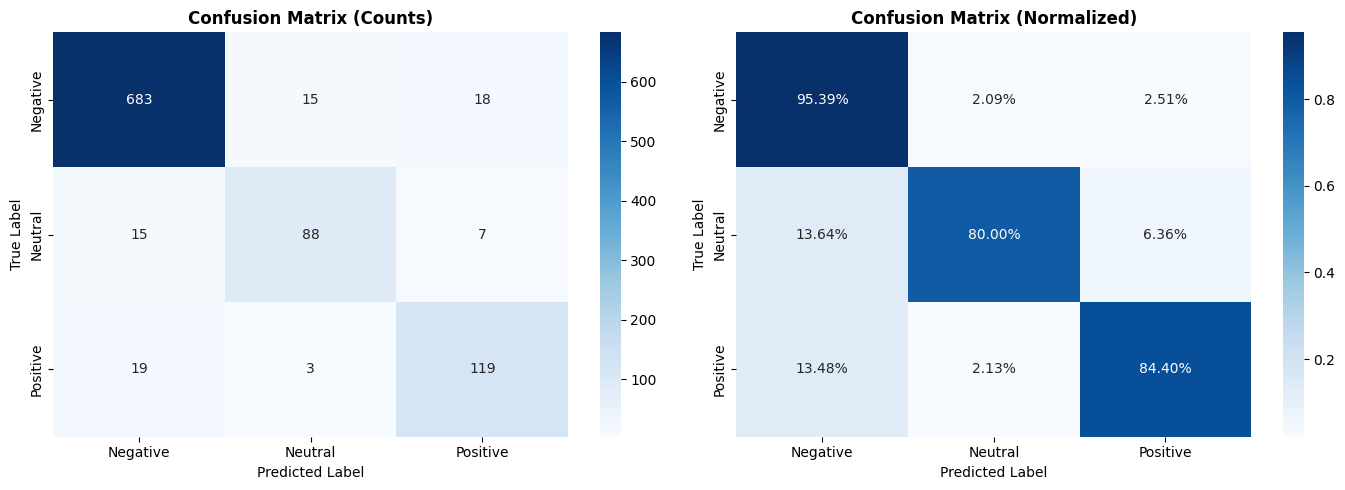

In [15]:
# CONFUSION MATRIX

cm = confusion_matrix(y_true, y_pred)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_names, yticklabels=label_names,
            ax=axes[0])
axes[0].set_title('Confusion Matrix (Counts)', fontweight='bold')
axes[0].set_ylabel('True Label')
axes[0].set_xlabel('Predicted Label')

cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_norm, annot=True, fmt='.2%', cmap='Blues',
            xticklabels=label_names, yticklabels=label_names,
            ax=axes[1])
axes[1].set_title('Confusion Matrix (Normalized)', fontweight='bold')
axes[1].set_ylabel('True Label')
axes[1].set_xlabel('Predicted Label')

plt.tight_layout()
plt.savefig('results/indobertweet_confusion_matrix.png', dpi=300, bbox_inches='tight')
print("Confusion matrix saved")
plt.show()

In [16]:
# ERROR ANALYSIS

misclassified_idx = np.where(y_pred != y_true)[0]
print(f"\nTotal misclassified: {len(misclassified_idx)} / {len(y_true)} "
      f"({len(misclassified_idx)/len(y_true)*100:.2f}%)")

print("\nSample Misclassifications:")
print("-" * 80)
for i, idx in enumerate(misclassified_idx[:5]):
    true_label = label_names[y_true[idx]]
    pred_label = label_names[y_pred[idx]]
    confidence = y_pred_probs[idx][y_pred[idx]]

    print(f"\n{i+1}. Text: {X_test[idx][:100]}...")
    print(f"   True: {true_label} | Predicted: {pred_label} | Confidence: {confidence:.4f}")


Total misclassified: 77 / 967 (7.96%)

Sample Misclassifications:
--------------------------------------------------------------------------------

1. Text: indonesia fakta...
   True: Neutral | Predicted: Negative | Confidence: 0.9976

2. Text: seandainya bangsa indonesia itutahu leluhur itu agamanya apa dan dapat di pastikan indonesia sudah m...
   True: Negative | Predicted: Positive | Confidence: 0.9917

3. Text: pak guru gembul islam sejati di indonesia menurut saya dari ntt semakin banyak orang beribadah pasti...
   True: Negative | Predicted: Positive | Confidence: 0.7766

4. Text: usir semua islam di papua jangan ada mesjid mushola dan oesantren di papya papua merdeka...
   True: Neutral | Predicted: Negative | Confidence: 0.9996

5. Text: semoga gembul jadi anggota dpr karena untuk saat ini hanya dia yg berani kritik dengan data dan pali...
   True: Negative | Predicted: Positive | Confidence: 0.9565


In [17]:
# SAVE MODEL

torch.save(model.state_dict(), 'models/indobertweet_model.bin')
tokenizer.save_pretrained('models/indobertweet_tokenizer')

print("Model saved: models/indobertweet_model.bin")
print("Tokenizer saved: models/indobertweet_tokenizer/")

Model saved: models/indobertweet_model.bin
Tokenizer saved: models/indobertweet_tokenizer/


In [18]:
# SAVE SUMMARY

summary = {
    'model_name': 'IndoBERTweet',
    'pretrained': MODEL_NAME,
    'parameters': trainable_params,
    'max_len': MAX_LEN,
    'batch_size': BATCH_SIZE,
    'epochs_trained': EPOCHS,
    'learning_rate': LEARNING_RATE,
    'best_val_accuracy': float(best_accuracy),
    'test_accuracy': float(test_acc),
    'test_loss': float(test_loss),
    'macro_f1': float(macro_f1),
    'weighted_f1': float(weighted_f1),
    'per_class_f1': {
        'negative': float(f1[0]),
        'neutral': float(f1[1]),
        'positive': float(f1[2])
    }
}

with open('results/indobertweet_summary.pkl', 'wb') as f:
    pickle.dump(summary, f)

print("\nIndoBERTweet Model Summary:")
print("-" * 80)
for key, value in summary.items():
    if key != 'per_class_f1':
        print(f"{key:20s}: {value}")


IndoBERTweet Model Summary:
--------------------------------------------------------------------------------
model_name          : IndoBERTweet
pretrained          : indolem/indobertweet-base-uncased
parameters          : 110560515
max_len             : 128
batch_size          : 16
epochs_trained      : 5
learning_rate       : 2e-05
best_val_accuracy   : 0.9338159255429163
test_accuracy       : 0.9203722854188211
test_loss           : 0.5964522946332047
macro_f1            : 0.8677158249323135
weighted_f1         : 0.9202692611999382
